In [1]:
using PyCall
using XGPaint
using HDF5
using Healpix
using Unitful, UnitfulAstro
nmt = pyimport("pymaster")

freq = 143.0
flux_143 = h5read("/tigress/zequnl/radio/lagache_sed_massage/catalog_$(143.0).h5", "flux");
flux = h5read("/tigress/zequnl/radio/lagache_sed_massage/catalog_$(freq).h5", "flux")
θ = h5read("/tigress/zequnl/radio/lagache_sed_massage/catalog_$(freq).h5", "theta")
ϕ = h5read("/tigress/zequnl/radio/lagache_sed_massage/catalog_$(freq).h5", "phi");

LoadError: KeyError: key "redshift" not found

In [2]:
flux_cut = 7e-3
cut_array = flux_143 .> flux_cut
histogram(redshift[cut_array])

LoadError: UndefVarError: redshift not defined

In [2]:
using XGPaint
using Healpix
hp = pyimport("healpy")

using PyPlot
PyPlot.svg(true)
using Unitful, UnitfulAstro
import PhysicalConstants.CODATA2018: BoltzmannConstant, PlanckConstant, SpeedOfLightInVacuum

# CHANGE FOR DIFFERENT FREQUENCY ==========================
# print(KCMB_to_Jy_factor(freq * 1u"GHz"))

const TCMB = 2.725u"K"
xf(ν) = float(PlanckConstant) * ν / float(BoltzmannConstant) / TCMB
MJy_mul(ν) = 1.05e3 * expm1(xf(ν))^2 * exp(-xf(ν)) * (ν/100u"GHz")^(-4)
tSZ_mul(ν) = 1e6u"1/K" * TCMB * (xf(ν) * (exp(xf(ν))+1) / expm1(xf(ν)) - 4)

tSZ_mul (generic function with 1 method)

In [3]:
# plt.hist(log10.(flux))
# plt.axvline(log10.(flux_cut))
# # plt.yscale("log")

In [4]:
# nside = 4096
# radiomask = HealpixMap{Float64,RingOrder}(nside)
# flux_cut = 7e-3
# cut_array = flux_143 .> flux_cut  # in Jy
# XGPaint.catalog2map!(radiomask, flux[cut_array], θ[cut_array], ϕ[cut_array])

# maskize(x::T) where T = (x > zero(T)) ? zero(T) : one(T)
# radiomask .= maskize.(radiomask)

In [30]:
nside = 4096
flux_cut = 7e-3
sourcemask = HealpixMap{Float64,RingOrder}(nside)
XGPaint.catalog2map!(sourcemask, flux_143, θ, ϕ);

int_freq = round(Int, freq)
m_cib = readMapFromFITS("/tigress/zequnl/websky/cib_nu0$(int_freq).fits", 1, Float64);

include_cib = false
shuffle_vector = true

if include_cib
    sourcemask.pixels .+= m_cib.pixels .* 1e6
end;

In [31]:
# now to Jy
Ω_p = nside2pixarea(nside)
sourcemask.pixels .*= Ω_p

# now process
function cutmask!(m, cut)
    for i in eachindex(m.pixels)
        if sourcemask[i] > cut
            sourcemask[i] = 0.0
        else
            sourcemask[i] = 1.0
        end
    end
end

cutmask!(sourcemask, flux_cut);

In [32]:
using Random

In [27]:
sum((m_cib.pixels .* 1e6 .* Ω_p) .> flux_cut)

7648

In [28]:
# Plots.plot(radiomask)

In [35]:
if shuffle_vector
    sourcemask.pixels = Random.shuffle(sourcemask.pixels)
end

201326592-element Vector{Float64}:
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 ⋮
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0

In [36]:
import Plots
aposcale = 15/60
apo = HealpixMap{Float64,RingOrder}(
    nmt.mask_apodization(sourcemask.pixels, aposcale, apotype="C2"));

In [37]:
hp = pyimport("healpy")

PyObject <module 'healpy' from '/tigress/zequnl/shared/software/healpy/1.14.0/lib/python3.8/site-packages/healpy/__init__.py'>

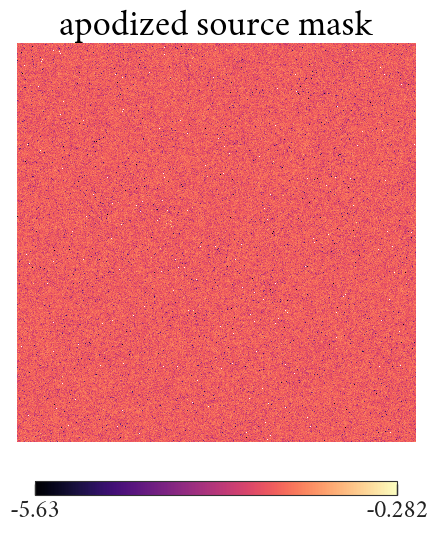

In [38]:
hp.cartview(log10.(m_cib.pixels), lonra=[-20.,20.], latra=[-20.,20.], title="apodized source mask")

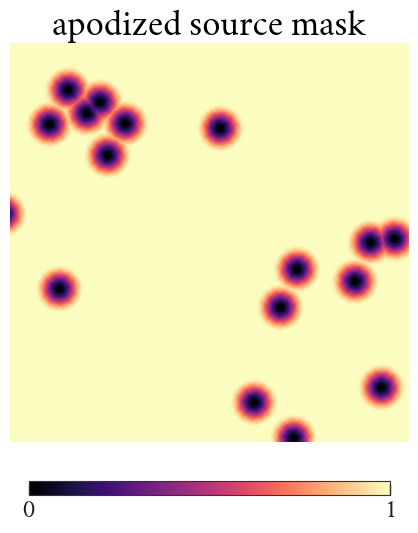

In [39]:
hp.cartview(apo.pixels, lonra=[-2.,2.], latra=[-2.,2.], title="apodized source mask")

In [40]:

shuffled = shuffle_vector ? "shuffled" : ""
if include_cib
    filename = "/tigress/zequnl/radio/$(shuffled)_cib_radio_apodized_15arcmin_7mJy_cut_at_143Ghz_mask.jld2"
else
    filename = "/tigress/zequnl/radio/$(shuffled)_radio_apodized_15arcmin_7mJy_cut_at_143Ghz_mask.jld2"
end

"/tigress/zequnl/radio/shuffled_radio_apodized_15arcmin_7mJy_cut_at_143Ghz_mask.jld2"

In [41]:
using JLD2
@save filename apo